# Dimensionality Reduction

In [1]:
import numpy as np

In [32]:
# Singular value decomposition (SVD)
X = np.random.randint(100, size=(5, 4, 1)) # 3D data
X_centered = X - X.mean(axis=0) # Center the data before reducing the dimensionality

U, s, Vt = np.linalg.svd(X_centered)

c1 = Vt[0]
c2 = Vt[0]

In [23]:
c1, c2

(array([[ 0.6214052 , -0.37318724,  0.6431312 ,  0.17958729,  0.16946245],
        [-0.11911831,  0.10418765,  0.22549008, -0.74828753,  0.60346977],
        [ 0.3707111 ,  0.8606888 ,  0.00728629,  0.25503855,  0.2380973 ],
        [ 0.52449096,  0.11335148, -0.12058584, -0.58486363, -0.59619986],
        [ 0.43260713, -0.31022968, -0.72176343,  0.02653409,  0.44154515]]),
 array([[ 0.6214052 , -0.37318724,  0.6431312 ,  0.17958729,  0.16946245],
        [-0.11911831,  0.10418765,  0.22549008, -0.74828753,  0.60346977],
        [ 0.3707111 ,  0.8606888 ,  0.00728629,  0.25503855,  0.2380973 ],
        [ 0.52449096,  0.11335148, -0.12058584, -0.58486363, -0.59619986],
        [ 0.43260713, -0.31022968, -0.72176343,  0.02653409,  0.44154515]]))

In [35]:
# Project the training set onto the plane
W2 = Vt[:2].T
X2D = X_centered @ W2

In [25]:
X2D.shape

(5, 4, 2)

In [44]:
# PCA with sklearn
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [77]:
pca = PCA(n_components=0.95) # preserve 95% of components
X_reduced = pca.fit_transform(X_train)

In [46]:
pca.n_components_

np.int64(154)

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))

param_dis = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)}

rnd_search = RandomizedSearchCV(clf, param_dis, n_iter=10, cv=3, random_state=42)

rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [48]:
rnd_search.best_params_ # n_components = to how many dims was reduced

{'randomforestclassifier__n_estimators': np.int64(475),
 'pca__n_components': np.int64(57)}

In [49]:
# How to decompress (it will not return previous 100% dataset (maybe 95%))
X_recovered = pca.inverse_transform(X_reduced)

(77, 2)

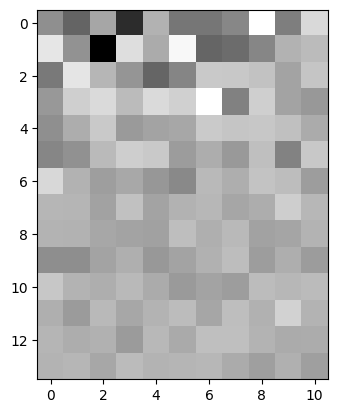

In [82]:
import matplotlib.pyplot as plt

plt.imshow(X_reduced[0].reshape(14, 11), cmap="binary")

In [79]:
# Randomized PCA
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [81]:
# Incremental PCA
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [83]:
# Another possibility is to save train data binary
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mmap[:] = X_train # Save data chunk by chunk
X_mmap.flush()

In [86]:
# Load
X_mmap = np.memmap(filename, dtype="float", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=300, n_components=154)

In [116]:
# Choose optimal number of dimensions
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, e = 5000, 0.1 # e (epsilon) determines that more than 10% of the data can't be lost

d = johnson_lindenstrauss_min_dim(n_samples=m, eps=e)
d

np.int64(7300)

In [110]:
# Use it
n = 20000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)
X_reduced = X @ P.T

In [111]:
# The same thing in one class
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [ ]:
# Inverse
# components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
# X_recovered = X_reduced @ components_pinv.T

In [113]:
# Locally Linear embedding (LLE)
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

# Unroll swiss roll
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

# 9.

In [120]:
from sklearn.datasets import load_digits

mnist = fetch_openml("mnist_784", as_frame=False)

70000

In [121]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

In [124]:
from sklearn.ensemble import RandomForestClassifier

rndf_clf = RandomForestClassifier(random_state=42)
rndf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [125]:
rndf_clf.score(X_test, y_test)

0.9705

In [129]:
pca = PCA()

pca.explained_variance_ratio_ = 0.95

X_reduced = pca.fit_transform(X_train)

In [ ]:
rndf_clf1 = RandomForestClassifier(random_state=42)
rndf_clf1.fit(X_reduced, y_train)

In [131]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd1 = SGDClassifier(random_state=42)

sgd.fit(X_train, y_train)
sgd1.fit(X_reduced, y_train)

KeyboardInterrupt: 

# 10.

In [160]:
from sklearn.manifold import TSNE

images = mnist.data[:5000]
y = mnist.target[:5000]

In [166]:
y = y.astype(int)

In [141]:
tsne = TSNE()

images_tsne = tsne.fit_transform(images)

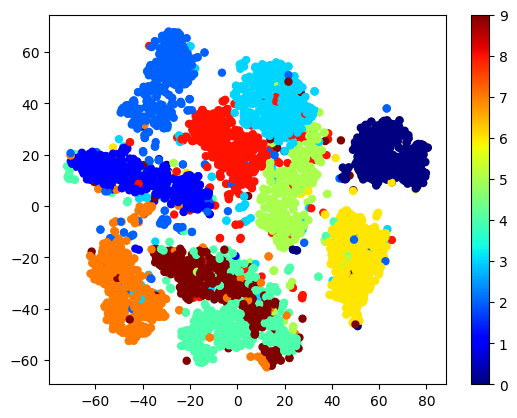

In [194]:
plt.scatter(images_tsne[:, 0], images_tsne[:, 1], s=25, c=y, cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
pca = PCA()

images_pca = pca.fit_transform(images)

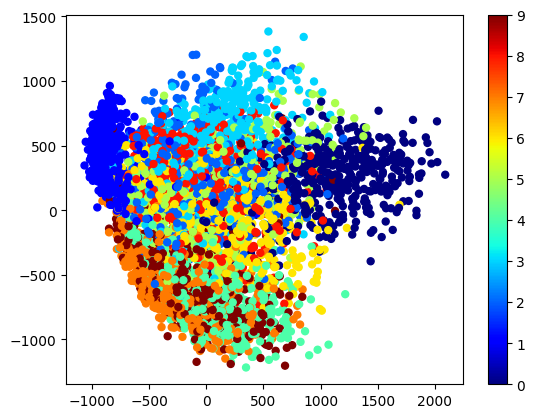

In [196]:
plt.scatter(images_pca[:, 0], images_pca[:, 1], s=25, c=y, cmap="jet")
plt.colorbar()
plt.show()

In [185]:
lle = LocallyLinearEmbedding()

images_lle = lle.fit_transform(images)

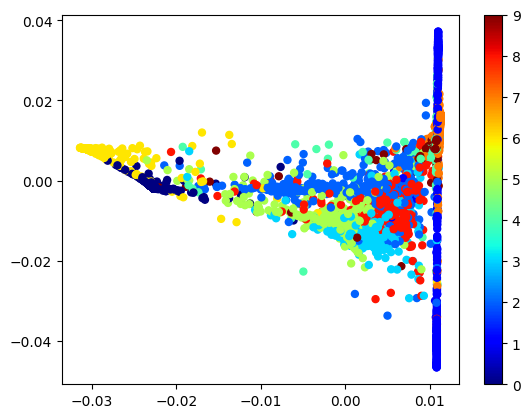

In [197]:
plt.scatter(images_lle[:, 0], images_lle[:, 1], s=25,c=y,cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
from sklearn.manifold import MDS

mds = MDS()

images_mds = mds.fit_transform(images)

In [ ]:
plt.scatter(images_mds[:, 0], images_mds[:, 1], s=25,c=y,cmap="jet")
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'T-SNE')

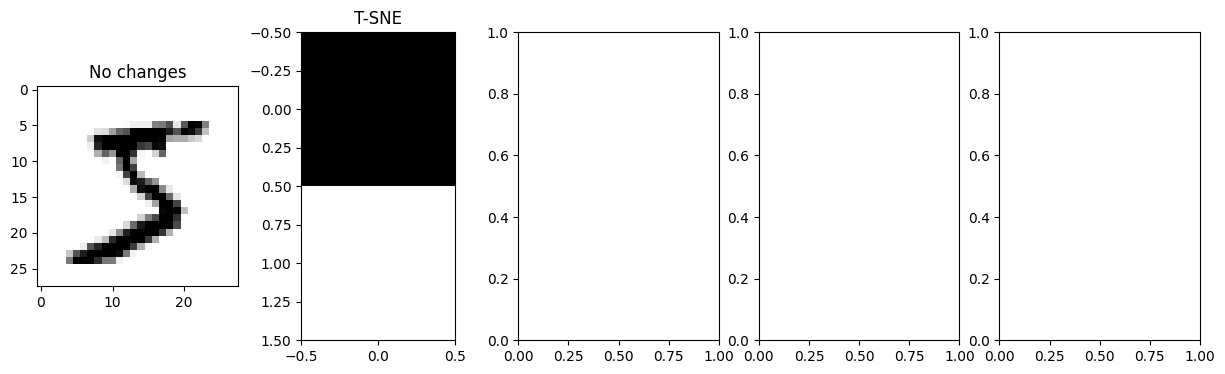

In [153]:
# Useless
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

axes[0].imshow(images[0].reshape(28, 28), cmap="binary")
axes[0].set_title("No changes")
axes[1].imshow(images_tsne[0].reshape(-1, 1), cmap="binary")
axes[1].set_title("T-SNE")